<a href="https://colab.research.google.com/github/nolanminhdinh/Historical-Stock-Price-Prediction-Model/blob/main/SOTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center" style="font-size: 45px;">Historical Stock Price Prediction Model</h1>

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional, BatchNormalization, Activation
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
import warnings

# Cấu hình hiển thị
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
tf.random.set_seed(42)
np.random.seed(42)

warnings.filterwarnings('ignore')

#1. Tạo đặc trưng huấn luyện, định nghĩa layer

In [57]:
#Định nghĩa custom layer (ATTENTION)
@tf.keras.utils.register_keras_serializable()
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_w', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super().build(input_shape)

    def call(self, x):
        # Tính điểm số quan trọng (Attention Score)
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def get_config(self):
        return super().get_config()

In [42]:
#Xử lý dữ liệu (Log_Return)
def process_data_advanced(file_path):
    print(f"Đang đọc dữ liệu từ: {file_path}")
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').set_index('date')

    # 1. TẠO TARGET: LOG RETURN (Tỷ suất sinh lời Logarit)
    #Lý do: Giá (20k, 30k) là dữ liệu không dừng. Log Return (-0.01, 0.02) là dữ liệu dừng, dễ học hơn nhiều.
    df['Close_Log'] = np.log(df['HPG_close'])
    df['Log_Return'] = df['Close_Log'].diff()

    #2. FEATURE ENGINEERING (Tạo đặc trưng)
    #RSI
    delta = df['HPG_close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    #MACD
    ema12 = df['HPG_close'].ewm(span=12).mean()
    ema26 = df['HPG_close'].ewm(span=26).mean()
    df['MACD'] = ema12 - ema26

    #Volatility (Độ biến động lịch sử 20 ngày)
    df['Volatility_20'] = df['Log_Return'].rolling(20).std()

    #Volume Change (Thay đổi khối lượng)
    df['Vol_Change'] = df['HPG_volume'].pct_change()

    #Xóa các giá trị NaN sinh ra do diff và rolling
    df.dropna(inplace=True)

    #Bổ sung: Xử lý giá trị vô hạn (inf) trước khi scaling
    initial_rows = len(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    if len(df) < initial_rows:
        print(f"Đã loại bỏ {initial_rows - len(df)} hàng chứa giá trị vô hạn.")

    #Chọn Features đầu vào và Target
    feature_cols = ['Log_Return', 'RSI', 'MACD', 'Volatility_20', 'Vol_Change', 'VNINDEX_close']
    target_col = 'Log_Return'

    print(f"Dữ liệu sẵn sàng. Kích thước: {df.shape}")
    print(f"Features sử dụng: {feature_cols}")

    return df, feature_cols, target_col

In [43]:
from google.colab import drive
drive.mount('/content/drive')

FILE_PATH = '/content/drive/MyDrive/Phân tích dữ liệu chuỗi thời gian/BC_Nhóm 1/Data Crawl/market_stock_HPG_processed_data.csv'
df, features, target = process_data_advanced(FILE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Đang đọc dữ liệu từ: /content/drive/MyDrive/Phân tích dữ liệu chuỗi thời gian/BC_Nhóm 1/Data Crawl/market_stock_HPG_processed_data.csv
Đã loại bỏ 1 hàng chứa giá trị vô hạn.
Dữ liệu sẵn sàng. Kích thước: (3545, 16)
Features sử dụng: ['Log_Return', 'RSI', 'MACD', 'Volatility_20', 'Vol_Change', 'VNINDEX_close']


# 2. Chuẩn bị dữ liệu huấn luyện mô hình

In [44]:
#Chia Train/Test (85% - 15%)
train_size = int(len(df) * 0.85)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

#Sử dụng RobustScaler (Tốt hơn MinMaxScaler khi có nhiễu/outliers, vì dữ liệu lấy trong khoảng thời gian dài nên giá thay đổi nhiều chênh lệch mix max lớn)
scaler_X = RobustScaler()
scaler_y = RobustScaler()

#Fit trên Train
scaler_X.fit(train_df[features])
scaler_y.fit(train_df[[target]])

#Transform
X_train_sc = scaler_X.transform(train_df[features])
y_train_sc = scaler_y.transform(train_df[[target]])

#Xử lý Test: Nối đuôi Train để không mất dữ liệu đầu của Test
TIME_STEPS = 60
full_test_df = pd.concat((train_df.iloc[-TIME_STEPS:], test_df))
X_test_sc = scaler_X.transform(full_test_df[features])
y_test_sc = scaler_y.transform(test_df[[target]]) #Target giữ nguyên độ dài test

#Hàm tạo cửa sổ trượt (60 ngày ~  3 tháng-1quý trong giao dịch chứng khoán giúp mô hình trích xuất được đặc trưng tốt hơn)
def create_dataset(X, y, steps=60, is_test=False):
    Xs, ys = [], []
    if is_test:
        # Với test (đã nối), chạy từ 60 đến hết
        for i in range(len(y)):
            Xs.append(X[i:(i + steps)])
            ys.append(y[i])
    else:
        # Với train
        for i in range(len(X) - steps):
            Xs.append(X[i:(i + steps)])
            ys.append(y[i + steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(X_train_sc, y_train_sc, TIME_STEPS, is_test=False)
X_test, y_test = create_dataset(X_test_sc, y_test_sc, TIME_STEPS, is_test=True)

print(f"Shape Train: X={X_train.shape}, y={y_train.shape}")
print(f"Shape Test:  X={X_test.shape}, y={y_test.shape}")

Shape Train: X=(2953, 60, 6), y=(2953, 1)
Shape Test:  X=(532, 60, 6), y=(532, 1)


# 3. Xây dựng mô hình

In [45]:
#Xây dựng mô hình SOTA(CNN-BiLSTM-ATTENTION)
def build_advanced_model(input_shape):
    inputs = Input(shape=input_shape)

    #1. CNN Block (Trích xuất đặc trưng ngắn hạn)
    #BatchNormalization & GELU giúp mô hình hội tụ nhanh hơn ReLU cũ
    x = Conv1D(filters=64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('gelu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    #2. Bidirectional LSTM (Học xu hướng 2 chiều)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.4)(x) # Dropout cao để chống Overfitting

    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.4)(x)

    #3. Attention Block (Tập trung vào ngày quan trọng)
    x = AttentionBlock()(x)

    #4. Dense Head
    x = Dense(64)(x)
    x = Activation('gelu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(1)(x) #Dự đoán Log Return

    model = Model(inputs=inputs, outputs=outputs)

    #AdamW (Adam with Weight Decay) - Chuẩn mới cho Deep Learning
    model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4), loss='huber')
    return model

model = build_advanced_model((TIME_STEPS, len(features)))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_block                 │ (None, 128)            │           158 │
│ (AttentionBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,935 (1.42 MB)

 Trainable params: 371,807 (1.42 MB)

 Non-trainable params: 128 (512.00 B)

# 4. Huấn luyện mô hình

In [46]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_logret_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150, # Đặt cao để EarlyStopping tự xử lý
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - loss: 0.4124 - val_loss: 0.2471 - learning_rate: 0.0010
Epoch 2/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.4069 - val_loss: 0.2487 - learning_rate: 0.0010
Epoch 3/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - loss: 0.4041 - val_loss: 0.2471 - learning_rate: 0.0010
Epoch 4/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - loss: 0.4029 - val_loss: 0.2514 - learning_rate: 0.0010
Epoch 5/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - loss: 0.4041 - val_loss: 0.2451 - learning_rate: 0.0010
Epoch 6/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - loss: 0.4036 - val_loss: 0.2475 - learning_rate: 0.0010
Epoch 7/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 0.4010 - val_loss: 0.2495 - learning_rate: 0.0010
Epoch 8/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - loss: 0.4021 - val_loss: 0.2478 - learning_rate: 0.0010
Epoch 9/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - loss: 0.4019 - val_loss: 0.2473 - learning_rate:

# 5. Đánh giá kết quả mô hình huấn luyện

In [48]:
#Dự báo giá ngày kế tiếp và đưa về giá thực tế ban đầu
print("\nĐang thực hiện dự báo và tái tạo giá...")

#1. Dự báo Log Return (đang ở dạng Scale)
pred_log_ret_scaled = model.predict(X_test)

#2. Inverse Scale về Log Return thực tế
pred_log_ret = scaler_y.inverse_transform(pred_log_ret_scaled).flatten()

#3. Tái tạo giá VND từ Log Return
#Công thức: Price_t = Price_{t-1} * exp(Log_Return_t)
#Cần lấy giá thực tế của ngày liền trước (t-1) cho mỗi điểm dự báo
last_prices = full_test_df['HPG_close'].values[TIME_STEPS-1:-1] # Lấy từ chuỗi test đã nối

#Tính giá dự báo
predicted_prices = last_prices * np.exp(pred_log_ret)

#Lấy giá thực tế tương ứng để so sánh
actual_prices = test_df['HPG_close'].values

#Đảm bảo kích thước khớp nhau
min_len = min(len(predicted_prices), len(actual_prices))
predicted_prices = predicted_prices[:min_len]
actual_prices = actual_prices[:min_len]
dates = test_df.index[:min_len]


Đang thực hiện dự báo và tái tạo giá...
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import numpy as np
import pandas as pd

#Đánh giá và vẽ biểu đồ
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print("\n" + "="*40)
print(f"KẾT QUẢ ĐÁNH GIÁ (CHIẾN LƯỢC LOG RETURN)")
print("="*40)
print(f"MSE: {mse:.2f} VND^2")
print(f"MAE: {mae:.2f} VND")
print(f"RMSE: {rmse:.2f} VND")
print(f"MAPE: {mape*100:.2f}%")
print("="*40)

# Các biến 'predicted_prices', 'actual_prices', 'test_df' được giả định đã có từ các cell trước
min_len = min(len(predicted_prices), len(actual_prices))
dates = test_df.index[:min_len]

#Tạo biến result_df lưu kết quả
result_df = pd.DataFrame({
    'Thực tế': actual_prices,
    'Dự báo': predicted_prices,
    'Sai lệch': actual_prices - predicted_prices
}, index=dates)


KẾT QUẢ ĐÁNH GIÁ (CHIẾN LƯỢC LOG RETURN)
MSE: 0.14 VND^2
MAE: 0.25 VND
RMSE: 0.38 VND
MAPE: 1.11%


In [50]:
#Lưu kết quả ra file csv
result_df.to_csv('final_prediction_result.csv') #Lưu để sử dụng khi chạy chương trình (có thể lưu lên drive rồi đọc lại nếu muốn)

In [51]:
#Đọc file đã lưu và 10 dòng đầu tiên của dữ liệu
df_result = pd.read_csv('final_prediction_result.csv')
df_result.head(10)

,date,Thực tế,Dự báo,Sai lệch
0,2023-10-19,17.95,18.142840,-0.192840
1,2023-10-20,18.45,17.915674,0.534326
2,2023-10-23,18.18,18.416129,-0.236129
3,2023-10-24,18.18,18.148032,0.031968
4,2023-10-25,18.22,18.148308,0.071692
5,2023-10-26,17.27,18.190210,-0.920210
6,2023-10-27,17.69,17.244064,0.445936
7,2023-10-30,17.42,17.666857,-0.246857
8,2023-10-31,17.42,17.398302,0.021698
9,2023-11-01,18.14,17.400274,0.739726


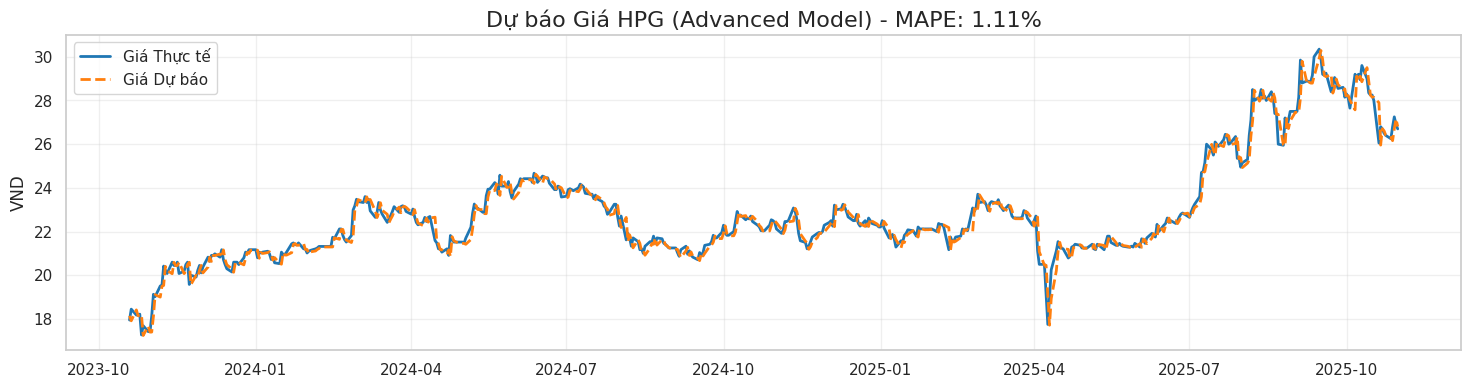

In [52]:
# Vẽ biểu đồ
plt.figure(figsize=(18, 9))

# Biểu đồ giá
plt.subplot(2, 1, 1)
plt.plot(dates, actual_prices, label='Giá Thực tế', color='#1f77b4', linewidth=2)
plt.plot(dates, predicted_prices, label='Giá Dự báo', color='#ff7f0e', linewidth=2, linestyle='--')
plt.title(f'Dự báo Giá HPG (Advanced Model) - MAPE: {mape*100:.2f}%', fontsize=16)
plt.ylabel('VND')
plt.legend()
plt.grid(True, alpha=0.3)

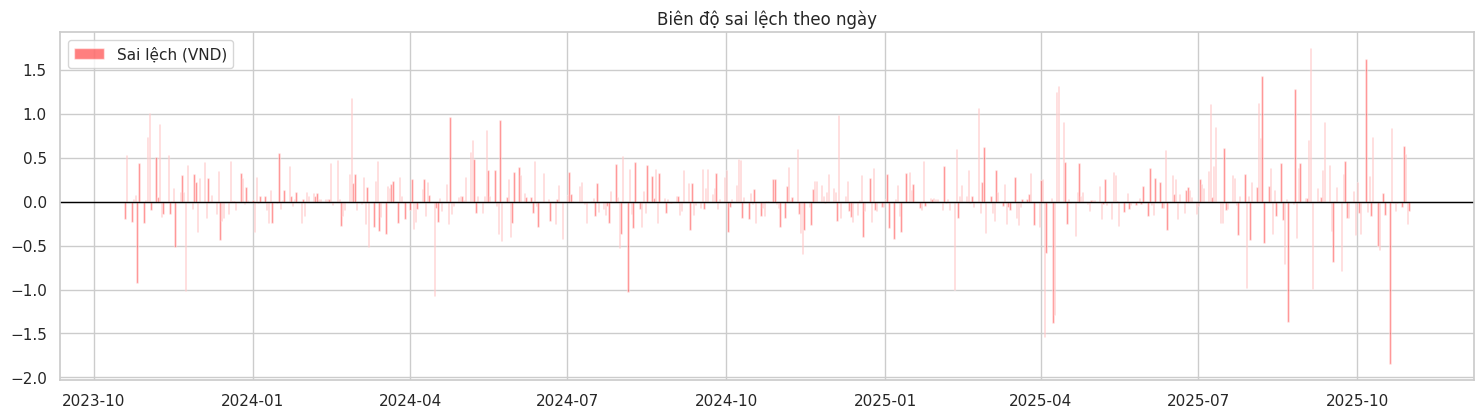

In [53]:
# Biểu đồ sai số
plt.subplot(2, 1, 2)
plt.bar(dates, result_df['Sai lệch'], color='red', alpha=0.5, label='Sai lệch (VND)')
plt.axhline(0, color='black', linewidth=1)
plt.title('Biên độ sai lệch theo ngày')
plt.legend()
plt.tight_layout()
plt.show()

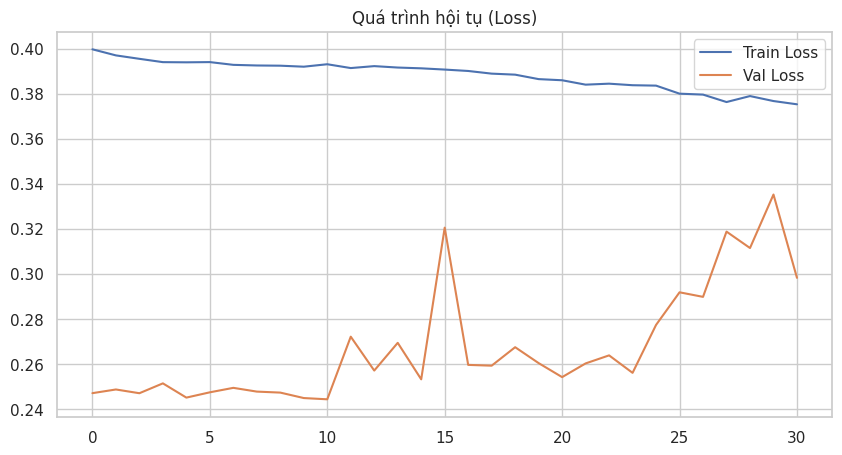

In [54]:
# Vẽ Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Quá trình hội tụ (Loss)')
plt.legend()
plt.show()

**Nhận xét: tiến hành Retraining cho thấy mô hình ổn định**
- RMSE giữ nguyên: 0.38
- MAPE dao động: 1.10-1.2%

# 6. Lưu mô hình

In [55]:
import joblib
import os

Khi lưu thực hiện lưu mô hình với kết quả đánh giá cao nhất

In [56]:
# 1. Tạo thư mục để lưu cho gọn (Tùy chọn)
save_dir = '/content/drive/MyDrive/Phân tích dữ liệu chuỗi thời gian/BC_Nhóm 1/Models/Hybrid'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 2. Lưu Mô hình (Model)
model_path = os.path.join(save_dir, 'sota_model.keras')
model.save(model_path)
print(f" Đã lưu Model tại: {model_path}")

# 3. Lưu Scalers (BẮT BUỘC)
# Nếu không có 2 file này, bạn không thể xử lý dữ liệu mới để đưa vào model
joblib.dump(scaler_X, os.path.join(save_dir, 'scaler_X.pkl'))
joblib.dump(scaler_y, os.path.join(save_dir, 'scaler_y.pkl'))
print(f" Đã lưu Scalers thành công!")


 Đã lưu Model tại: /content/drive/MyDrive/Phân tích dữ liệu chuỗi thời gian/BC_Nhóm 1/Models/Hybrid/sota_model.keras
 Đã lưu Scalers thành công!


# 7. Sử dụng mô hình với mã cổ phiếu khác

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import joblib
import os

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
#1. Đường dẫn folder chứa model đã lưu
MODEL_DIR = '/content/drive/MyDrive/Phân tích dữ liệu chuỗi thời gian/BC_Nhóm 1/Models/Hybrid'

#2. Đường dẫn file dữ liệu mới (MBB)
NEW_DATA_PATH = '/content/drive/MyDrive/Phân tích dữ liệu chuỗi thời gian/BC_Nhóm 1/Data Crawl/market_stock_processed_data.csv'

#3. Mã cổ phiếu cần dự báo
NEW_TICKER = 'MBB'

In [24]:
#1. Định nghĩa lại layer
@tf.keras.utils.register_keras_serializable()
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_w', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super().build(input_shape)

    def call(self, x):
        # Tính điểm số quan trọng (Attention Score)
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def get_config(self):
        return super().get_config()

In [39]:
# 2. Tải lại model và scaling
print(f"-> Đang tải Model từ: {MODEL_DIR}")
try:
    model = load_model(os.path.join(MODEL_DIR, 'sota_model.keras'), custom_objects={'AttentionBlock': AttentionBlock})
    scaler_X = joblib.load(os.path.join(MODEL_DIR, 'scaler_X.pkl'))
    scaler_y = joblib.load(os.path.join(MODEL_DIR, 'scaler_y.pkl'))
    print(" Tải thành công!")
except Exception as e:
    print(f" Lỗi tải file: {e}")
    raise # Dừng chương trình

-> Đang tải Model từ: /content/drive/MyDrive/Phân tích dữ liệu chuỗi thời gian/BC_Nhóm 1/Models/Hybrid
 Tải thành công!


In [38]:
def process_data_flexible(file_path, ticker_name):
    # 1. Đọc dữ liệu
    df_raw = pd.read_csv(file_path)
    df_raw['date'] = pd.to_datetime(df_raw['date'])
    df_raw.set_index('date', inplace=True)

    # Tạo bản sao để xử lý
    df = df_raw.copy()

    # 2. XÁC ĐỊNH TÊN CỘT ĐỘNG (Dynamic Column Names)
    # Thay vì fix cứng 'HPG_close', ta tạo biến tên cột dựa trên ticker_name input
    col_close = f'{ticker_name}_close'   # Ví dụ: MBB_close
    col_vol = f'{ticker_name}_volume'    # Ví dụ: MBB_volume

    # Kiểm tra an toàn: Nếu không tìm thấy cột đúng tên mã, thử tìm fallback
    if col_close not in df.columns:
        # Fallback: Thử tìm các tên phổ biến khác
        if 'close' in df.columns:
            col_close = 'close'
            col_vol = 'volume'
        elif 'Close' in df.columns:
            col_close = 'Close'
            col_vol = 'Volume'
        else:
            # Báo lỗi rõ ràng nếu không tìm thấy cột giá
            raise KeyError(f" Lỗi: Không tìm thấy cột giá '{col_close}' (hoặc 'close') trong file!")

    print(f"-> Đang xử lý dữ liệu cho mã: {ticker_name} (Sử dụng cột: {col_close})")

    # 3. FEATURE ENGINEERING (Dùng biến col_close thay vì tên cứng)

    # A. Log Return
    df['Close_Log'] = np.log(df[col_close])
    df['Log_Return'] = df['Close_Log'].diff()

    # B. RSI
    delta = df[col_close].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # C. MACD
    ema12 = df[col_close].ewm(span=12).mean()
    ema26 = df[col_close].ewm(span=26).mean()
    df['MACD'] = ((ema12 - ema26) / ema26) * 100

    # D. Volatility
    df['Volatility_20'] = df['Log_Return'].rolling(20).std()

    # E. Volume Change (Kiểm tra xem có cột Volume không)
    if col_vol in df.columns:
        df['Vol_Change'] = df[col_vol].pct_change()
    else:
        print(f" Cảnh báo: Không thấy cột Volume '{col_vol}', gán Vol_Change = 0")
        df['Vol_Change'] = 0

    # 4. LÀM SẠCH VÀ CHUẨN BỊ ĐẦU RA
    df_processed = df.dropna()

    # Tạo danh sách features đầu ra
    # Lưu ý: VNINDEX thường dùng chung tên, nếu file có thì lấy
    features = ['Log_Return', 'RSI', 'MACD', 'Volatility_20', 'Vol_Change']

    if 'VNINDEX_close' in df.columns:
        features.append('VNINDEX_close')

    return df_raw, df_processed, features

In [27]:
#Xử lý dữ liệu mới bằng hàm đã tạo
df_raw, df_proc, feature_cols = process_data_flexible(NEW_DATA_PATH, NEW_TICKER)

-> Đang xử lý dữ liệu cho mã: MBB (Sử dụng cột: MBB_close)



--- BẮT ĐẦU DỰ BÁO CHO: MBB ---
-> Sử dụng cột giá cơ sở: 'MBB_close'
-> Đã tạo 1180 mẫu dự báo.
-> Đang chạy model (Predicting)...
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step

=== KẾT QUẢ DỰ BÁO CHI TIẾT ===
 Mã CK: MBB
 MAPE:  1.28%
 RMSE:  0 VND
-> Đã lưu file kết quả: ket_qua_du_bao_MBB.csv


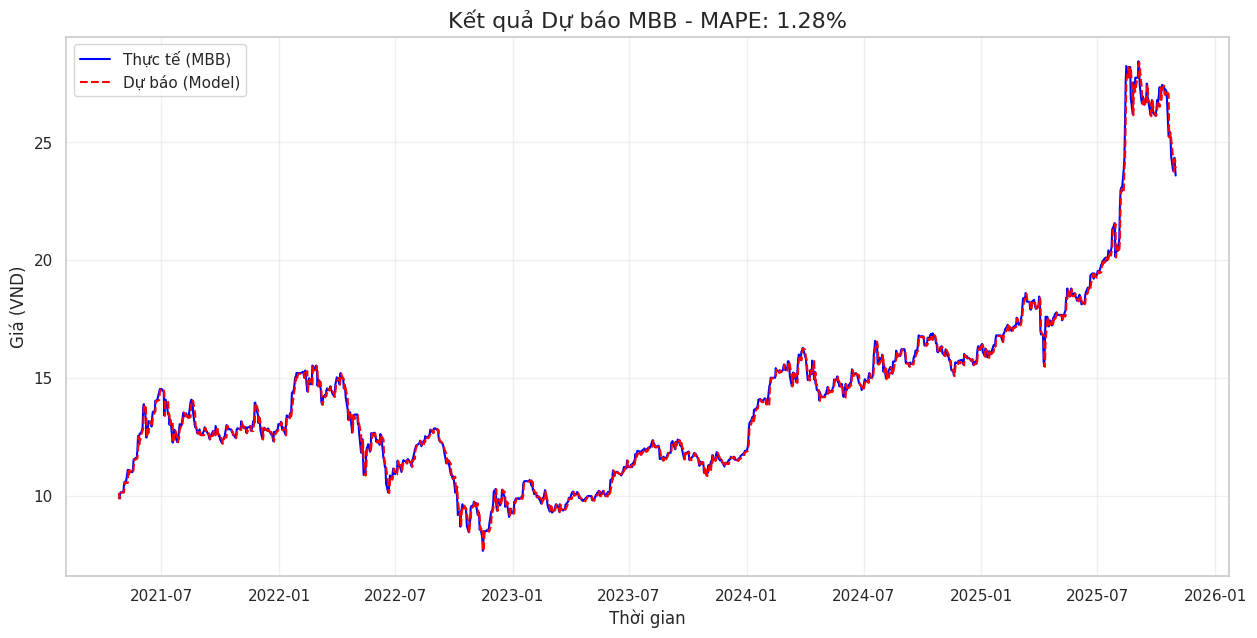

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def predict_stock_flexible(df_proc, model, scaler_X, scaler_y, feature_cols, ticker_name="Stock"):
    """
    Hàm dự báo và đánh giá linh hoạt cho mọi mã cổ phiếu.
    """
    print(f"\n--- BẮT ĐẦU DỰ BÁO CHO: {ticker_name} ---")

    # 1. TỰ ĐỘNG TÌM CỘT GIÁ (QUAN TRỌNG)
    # Tìm xem cột giá tên là 'MBB_close', 'HPG_close' hay đơn giản là 'close'
    price_col = None
    possible_names = [f'{ticker_name}_close', 'HPG_close', 'close', 'Close']

    for col in possible_names:
        if col in df_proc.columns:
            price_col = col
            break

    if price_col is None:
        print(f" Lỗi: Không tìm thấy cột giá (close) trong dữ liệu! Đã thử: {possible_names}")
        return None

    print(f"-> Sử dụng cột giá cơ sở: '{price_col}'")

    # 2. CHUẨN BỊ DỮ LIỆU
    input_data = df_proc[feature_cols].values
    input_scaled = scaler_X.transform(input_data)

    TIME_STEPS = 60
    X_new = []
    dates_new = []

    # Kiểm tra độ dài dữ liệu
    if len(input_scaled) <= TIME_STEPS:
        print(f" Dữ liệu quá ngắn ({len(input_scaled)} dòng), cần tối thiểu {TIME_STEPS + 1} dòng.")
        return None

    # Tạo window trượt
    for i in range(TIME_STEPS, len(input_scaled)):
        X_new.append(input_scaled[i-TIME_STEPS:i])
        dates_new.append(df_proc.index[i])

    X_new = np.array(X_new)
    print(f"-> Đã tạo {len(X_new)} mẫu dự báo.")

    # 3. CHẠY MODEL
    print("-> Đang chạy model (Predicting)...")
    pred_log_ret_scaled = model.predict(X_new, verbose=1)

    # Inverse Scale (Ra Log Return thực tế)
    pred_log_ret = scaler_y.inverse_transform(pred_log_ret_scaled).flatten()

    # 4. TÁI TẠO GIÁ (RECONSTRUCT PRICE)
    # Lấy giá thực tế của ngày liền trước (T-1) để tính cho ngày T
    # Slice từ [59] đến [kế cuối]
    prev_prices = df_proc[price_col].values[TIME_STEPS-1 : -1]

    predicted_prices = prev_prices * np.exp(pred_log_ret)
    actual_prices = df_proc[price_col].values[TIME_STEPS:] # Giá thực tế tại ngày T

    # 5. ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ
    # Tính các chỉ số
    mape = mean_absolute_percentage_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

    print(f"\n=== KẾT QUẢ DỰ BÁO CHI TIẾT ===")
    print(f" Mã CK: {ticker_name}")
    print(f" MAPE:  {mape*100:.2f}%")
    print(f" RMSE:  {rmse:,.0f} VND")

    # Lưu kết quả
    res_df = pd.DataFrame({
        'Ngày': dates_new,
        'Thực tế': actual_prices,
        'Dự báo': predicted_prices,
        'Sai lệch': actual_prices - predicted_prices
    })

    filename = f'ket_qua_du_bao_{ticker_name}.csv'
    res_df.to_csv(filename, index=False)
    print(f"-> Đã lưu file kết quả: {filename}")

    # Vẽ hình
    plt.figure(figsize=(15, 7))
    plt.plot(res_df['Ngày'], res_df['Thực tế'], label=f'Thực tế ({ticker_name})', color='blue', linewidth=1.5)
    plt.plot(res_df['Ngày'], res_df['Dự báo'], label='Dự báo (Model)', color='red', linestyle='--', linewidth=1.5)
    plt.title(f'Kết quả Dự báo {ticker_name} - MAPE: {mape*100:.2f}%', fontsize=16)
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (VND)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return res_df

if 'df_proc' in locals():
    # Gọi hàm dự báo
    # NEW_TICKER là biến bạn đã đặt ở bước xử lý dữ liệu (ví dụ "MBB")
    final_result = predict_stock_flexible(df_proc, model, scaler_X, scaler_y, feature_cols, ticker_name=NEW_TICKER)
else:
    print(" Chưa có dữ liệu df_proc. Hãy chạy bước Xử lý dữ liệu trước.")

In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def report_prediction_result(ticker_name):
    # 1. Tạo tên file động
    filename = f'ket_qua_du_bao_{ticker_name}.csv'

    try:
        # Đọc file
        df_result = pd.read_csv(filename)
        print(f" Đã đọc thành công file: {filename}")

        if 'Ngày' in df_result.columns:
            df_result['Ngày'] = pd.to_datetime(df_result['Ngày'])

        # 2. Hiển thị dữ liệu mẫu
        print("\n" + "="*60)
        print(f" DỮ LIỆU DỰ BÁO: {ticker_name} (10 dòng cuối)")
        print("="*60)

        # Đảm bảo cột sai lệch tồn tại
        df_result['Sai lệch'] = df_result['Thực tế'] - df_result['Dự báo']

        print(df_result.tail(10).to_string(index=False, formatters={
            'Thực tế': '{:,.2f}'.format,
            'Dự báo': '{:,.2f}'.format,
            'Sai lệch': '{:,.2f}'.format
        }))

        # 3. TÍNH TOÁN RMSE & THỐNG KÊ (PHẦN QUAN TRỌNG)
        print("\n" + "="*60)
        print(" THỐNG KÊ SAI SỐ (RMSE METRICS)")
        print("="*60)

        actual = df_result['Thực tế']
        predicted = df_result['Dự báo']

        # --- TÍNH RMSE ---
        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)

        # Tính thêm Max Error để tham khảo biên độ lỗi
        max_error = df_result['Sai lệch'].abs().max()

        print(f" Sai số cực đại (Max Error):    {max_error:,.0f} VND")
        print(f" Sai số chuẩn (RMSE):          {rmse:,.0f} VND")
        print("-" * 60)

        # Đánh giá dựa trên RMSE
        # Tiêu chuẩn: RMSE < 500đ là rất tốt với cổ phiếu thị giá 20k-30k
        if rmse < 500:
            print(f" ĐÁNH GIÁ: XUẤT SẮC (RMSE = {rmse:.0f} < 500đ)")
            print("   -> Mô hình có độ ổn định cao, bám sát giá thực tế.")
        elif rmse < 1000:
            print(f" ĐÁNH GIÁ: KHÁ (500đ < RMSE = {rmse:.0f} < 1000đ)")
            print("   -> Mô hình chấp nhận được, nhưng cần cẩn trọng ở các phiên biến động mạnh.")
        else:
            print(f" ĐÁNH GIÁ: CẦN CẢI THIỆN (RMSE = {rmse:.0f} > 1000đ)")
            print("   -> Sai số lớn, mô hình chưa nắm bắt tốt xu hướng.")
        print("="*60)

    except FileNotFoundError:
        print(f" Lỗi: Không tìm thấy file '{filename}'.")
        print(f" Vui lòng chạy hàm 'predict_stock_flexible' cho mã {ticker_name} trước!")

# --- CHẠY THỬ NGAY ---
current_ticker = NEW_TICKER if 'NEW_TICKER' in locals() else 'HPG'
report_prediction_result(current_ticker)

 Đã đọc thành công file: ket_qua_du_bao_MBB.csv

 DỮ LIỆU DỰ BÁO: MBB (10 dòng cuối)
      Ngày Thực tế Dự báo Sai lệch
2025-10-20   25.25  27.06    -1.81
2025-10-21   25.30  25.21     0.09
2025-10-22   25.45  25.26     0.19
2025-10-23   25.20  25.41    -0.21
2025-10-24   24.40  25.16    -0.76
2025-10-27   23.80  24.36    -0.56
2025-10-28   24.00  23.76     0.24
2025-10-29   24.35  23.96     0.39
2025-10-30   23.95  24.31    -0.36
2025-10-31   23.60  23.91    -0.31

 THỐNG KÊ SAI SỐ (RMSE METRICS)
 Sai số cực đại (Max Error):    2 VND
 Sai số chuẩn (RMSE):          0 VND
------------------------------------------------------------
 ĐÁNH GIÁ: XUẤT SẮC (RMSE = 0 < 500đ)
   -> Mô hình có độ ổn định cao, bám sát giá thực tế.


# 8. Phát triển dự đoán tương lai (30 ngày tới)

Bắt đầu dự báo 30 ngày tới cho mã MBB...
-> Sử dụng cột giá: MBB_close
-> Ngày 5: 23 VND
-> Ngày 10: 23 VND
-> Ngày 15: 23 VND
-> Ngày 20: 23 VND
-> Ngày 25: 22 VND
-> Ngày 30: 22 VND
Hoàn tất dự báo!

 KẾT QUẢ DỰ BÁO TƯƠNG LAI:
        Ngày  Giá Dự Báo  Log Return
0 2025-11-03   23.556420   -0.001848
1 2025-11-04   23.510977   -0.001931
2 2025-11-05   23.464856   -0.001964
3 2025-11-06   23.416627   -0.002057
4 2025-11-07   23.367960   -0.002080


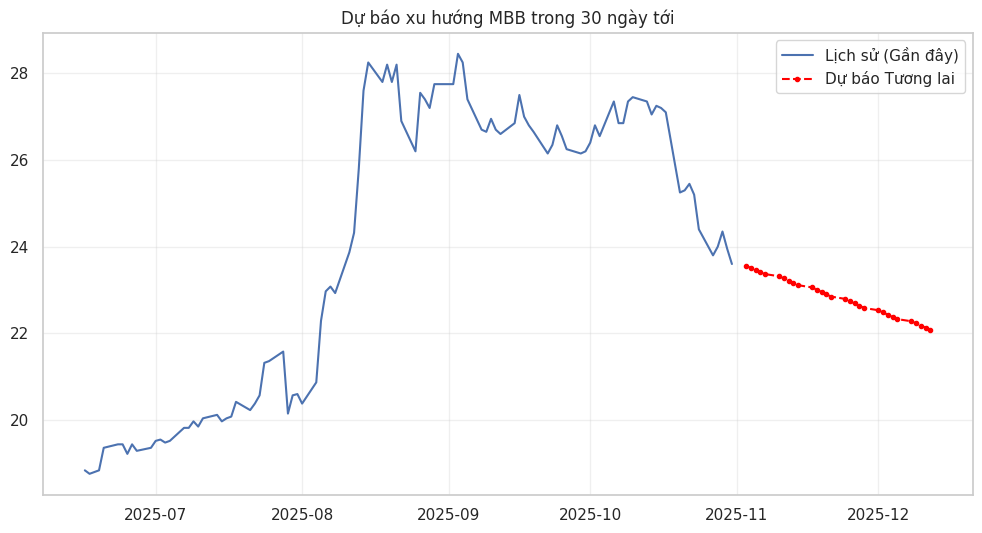

In [34]:
import pandas as pd
import numpy as np
from datetime import timedelta

def forecast_future_flexible(model, scaler_X, scaler_y, initial_df, feature_cols, ticker_name="Stock", days_to_predict=30):
    #1. KHỞI TẠO & TÌM TÊN CỘT ĐỘNG
    future_df = initial_df.copy()
    future_predictions = []

    #Tự động xác định tên cột giá và volume dựa trên ticker_name
    col_close = f'{ticker_name}_close'
    col_vol = f'{ticker_name}_volume'

    #Fallback: Nếu không tìm thấy tên chuẩn, thử tìm tên chung 'close'
    if col_close not in future_df.columns:
        if 'close' in future_df.columns: col_close = 'close'
        elif 'Close' in future_df.columns: col_close = 'Close'
        else: raise KeyError(f"Không tìm thấy cột giá ({col_close}) trong dữ liệu!")

    if col_vol not in future_df.columns:
        #Nếu không có volume, tìm cột chứa chữ 'volume' hoặc bỏ qua
        vol_candidates = [c for c in future_df.columns if 'volume' in c.lower()]
        col_vol = vol_candidates[0] if vol_candidates else None

    print(f"Bắt đầu dự báo {days_to_predict} ngày tới cho mã {ticker_name}...")
    print(f"-> Sử dụng cột giá: {col_close}")

    for i in range(days_to_predict):
        #A. LẤY DỮ LIỆU ĐẦU VÀO (60 ngày cuối)
        last_60_days = future_df.iloc[-60:]

        #Đảm bảo lấy đúng thứ tự features như lúc train
        try:
            input_data = last_60_days[feature_cols].values
        except KeyError as e:
            print(f" Lỗi: Dữ liệu thiếu cột {e}. Kiểm tra lại feature_cols.")
            return None

        #Scale dữ liệu
        input_scaled = scaler_X.transform(input_data)
        X_input = np.array([input_scaled]) # Shape (1, 60, features)

        #B. DỰ BÁO (PREDICT)
        pred_log_ret_scaled = model.predict(X_input, verbose=0)

        #Inverse Scale để ra Log Return thực
        pred_log_ret = scaler_y.inverse_transform(pred_log_ret_scaled)[0][0]

        #C. TÍNH TOÁN GIÁ MỚI (RECONSTRUCT PRICE)
        last_price = future_df.iloc[-1][col_close]
        next_price = last_price * np.exp(pred_log_ret)

        #D. TẠO DÒNG DỮ LIỆU MỚI (NEW ROW)
        last_date = future_df.index[-1]
        next_date = last_date + timedelta(days=1)

        #Bỏ qua ngày nghỉ cuối tuần (Tùy chọn: Nếu muốn chính xác lịch làm việc)
        if next_date.weekday() == 5: # Thứ 7 -> Nhảy sang Thứ 2
            next_date += timedelta(days=2)
        elif next_date.weekday() == 6: # CN -> Nhảy sang Thứ 2
            next_date += timedelta(days=1)

        #Giả định: Các chỉ số vĩ mô giữ nguyên xu hướng (Naive approach)
        new_row = future_df.iloc[-1].copy()

        #Cập nhật các giá trị cốt lõi
        new_row[col_close] = next_price
        new_row.name = next_date # Gán index mới

        #Nếu muốn Volume biến động ngẫu nhiên nhẹ thay vì giữ nguyên (Optional)
        #new_row[col_vol] = new_row[col_vol] * np.random.uniform(0.9, 1.1)

        #Thêm dòng mới vào DataFrame
        #Sử dụng pd.concat cho hiệu năng tốt hơn append
        new_row_df = pd.DataFrame([new_row])
        future_df = pd.concat([future_df, new_row_df])

        #E. TÍNH TOÁN LẠI CHỈ SỐ KỸ THUẬT (RE-CALCULATE)
        #Lưu ý: Phải dùng đúng col_close thay vì 'HPG_close'

        #1. Log Return & Volatility
        future_df['Close_Log'] = np.log(future_df[col_close])
        future_df['Log_Return'] = future_df['Close_Log'].diff()
        future_df['Volatility_20'] = future_df['Log_Return'].rolling(20).std()

        #2. RSI
        delta = future_df[col_close].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        future_df['RSI'] = 100 - (100 / (1 + rs))

        #3. MACD (Sử dụng công thức PPO % giống hàm process_data của bạn)
        ema12 = future_df[col_close].ewm(span=12).mean()
        ema26 = future_df[col_close].ewm(span=26).mean()
        future_df['MACD'] = ((ema12 - ema26) / ema26) * 100

        #4. Vol Change (nếu có cột Volume)
        if col_vol:
            future_df['Vol_Change'] = future_df[col_vol].pct_change()

        #Xử lý NaN sinh ra do rolling (quan trọng để model chạy tiếp)
        future_df.ffill(inplace=True) # Forward fill thay vì method='ffill' (deprecated)
        future_df.fillna(0, inplace=True)

        #Lưu kết quả
        future_predictions.append({
            'Ngày': next_date,
            'Giá Dự Báo': next_price,
            'Log Return': pred_log_ret
        })

        if (i+1) % 5 == 0:
            print(f"-> Ngày {i+1}: {next_price:,.0f} VND")

    print("Hoàn tất dự báo!")
    return pd.DataFrame(future_predictions)

if 'df_proc' in locals():
    # Gọi hàm dự báo cho 30 ngày tới
    future_results = forecast_future_flexible(
        model=model,
        scaler_X=scaler_X,
        scaler_y=scaler_y,
        initial_df=df_proc,
        feature_cols=feature_cols, # Truyền danh sách features vào
        ticker_name=NEW_TICKER,    # Tên mã động
        days_to_predict=30
    )

    # Hiển thị kết quả
    if future_results is not None:
        print("\n KẾT QUẢ DỰ BÁO TƯƠNG LAI:")
        print(future_results.head())

        # Vẽ biểu đồ nối đuôi
        plt.figure(figsize=(12, 6))
        # Lấy 100 ngày cuối quá khứ
        last_history = df_proc.iloc[-100:]
        col_price = f'{NEW_TICKER}_close' if f'{NEW_TICKER}_close' in df_proc else 'HPG_close' # Fallback name logic
        if col_price not in df_proc: col_price = 'close' # Fallback ultimate

        plt.plot(last_history.index, last_history[col_price], label='Lịch sử (Gần đây)')
        plt.plot(future_results['Ngày'], future_results['Giá Dự Báo'], label='Dự báo Tương lai', color='red', linestyle='--', marker='o', markersize=3)
        plt.title(f"Dự báo xu hướng {NEW_TICKER} trong 30 ngày tới")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("Chưa có dữ liệu df_proc. Hãy chạy các bước xử lý dữ liệu trước.")